In [2]:
import pandas as pd
import joblib
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import optuna
import xgboost as xgb
import sklearn.svm
import sklearn.ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
import sklearn.model_selection
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
import seaborn as sns

In [2]:
data = pd.read_csv('dataset.csv')
data.columns
data.iloc[:,-1] = np.log(data.iloc[:,-1])
# data=data[(data['EC'] <= 12)]

Index(['Alloys', 'EC'], dtype='object')

In [3]:
from matminer.featurizers.conversions import StrToComposition
df = StrToComposition().featurize_dataframe(data,'Alloys',pbar=False)
from matminer.featurizers.composition.alloy import WenAlloys
ep_feat = WenAlloys()
df = ep_feat.featurize_dataframe(df,col_id='composition',pbar=False)
from matminer.featurizers.composition import ElementProperty
ep_feat = ElementProperty.from_preset(preset_name='magpie')
df_ = ep_feat.featurize_dataframe(df,col_id='composition',pbar=False)
df_.to_csv('dataset/df.csv')
col = ['Yang omega', 'Configuration entropy','Atomic weight mean','Electronegativity delta',
        'VEC mean', 'Mixing enthalpy', 'Shear modulus mean','MagpieData mean Number',
        'MagpieData mean MeltingT','MagpieData mean CovalentRadius','MagpieData mean Electronegativity',
        'EC'
    ]
dataset = df_[col]

In [7]:
#初始数据
y = dataset.iloc[:,-1]
x = dataset.iloc[:,:-1]
dataset.head()
pd.concat((x,y),axis=1).to_csv('dataset/x_y_实验.csv',index=False)

In [10]:
col = ['Configuration entropy', 'Electronegativity delta', 'Mixing enthalpy',
       'Shear modulus mean', 'MagpieData mean Number',
       'MagpieData mean MeltingT', 'MagpieData mean CovalentRadius',
       'MagpieData mean Electronegativity', 'EC']
dataset[col].to_csv('dataset/data_final_exp_add.csv',index=False)

In [67]:

# def objective1(trial): 
#     loo = LeaveOneOut()
    
#     params = { 
#          "n_estimators" : trial.suggest_int('n_estimators', 0, 1000),
#           'max_depth':trial.suggest_int('max_depth', 2, 25),
#                 'reg_alpha':trial.suggest_int('reg_alpha', 1, 5),
#                 'reg_lambda':trial.suggest_int('reg_lambda', 1, 5),
#                 'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
#                 'gamma':trial.suggest_int('gamma', 0, 5),
#                 'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
#                 'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
#                 'nthread' : -1,'n_job':-1
#         } 
#     model = xgb.XGBRegressor(**params)
    
#     score = cross_val_score(model, x, y, cv = 10, n_jobs=-1, scoring="neg_mean_squared_error").mean() 

#     return score

def objective2(trial):
    loo = LeaveOneOut()
    svc_c = trial.suggest_int("C", 1, 1000, log=True)
    svr_g = trial.suggest_float('gamma',0.1,1.00, log = True)
    model = sklearn.svm.SVR(C=svc_c, gamma=svr_g, kernel='rbf')
    classifier_obj = make_pipeline(StandardScaler(),model)
    score = sklearn.model_selection.cross_val_score(classifier_obj,
                x, y, n_jobs=-1, cv=loo,scoring ='neg_mean_squared_error')
    accuracy = score.mean()
    return accuracy

def objective3(trial):
    loo = LeaveOneOut()
    rf_max_depth = trial.suggest_int("max_depth", 5, 32, log=True)
    n = trial.suggest_int('n_estimator',5,50,log = True)
    classifier_obj = sklearn.ensemble.RandomForestRegressor(
            max_depth=rf_max_depth, n_estimators=n,random_state=36
        )
    score = sklearn.model_selection.cross_val_score(classifier_obj,
                x, y, n_jobs=-1, cv=loo,scoring ='neg_mean_squared_error')
    accuracy = score.mean()
    return accuracy

In [68]:
# "XGBT"
# study = optuna.create_study(direction='maximize')
# study.optimize( objective2,n_trials= 500)
# joblib.dump(study, "./dataset/study.pkl")
# # x,x_test,y,y_test = train_test_split(x_,y_,test_size=0.2,random_state=46)
# loo = LeaveOneOut()
# model1 = xgb.XGBRegressor(**study.best_params)
# score = cross_val_score(model1, x, y, cv = loo, n_jobs=-1, scoring="neg_mean_squared_error")
# y_pre1 = sklearn.model_selection.cross_val_predict(model1,
#                     x, y, n_jobs=-1, cv=loo)
# r1 = np.corrcoef(y, y_pre1)
# accuracy1 = abs(score).mean()**0.5
# para1 = study.best_params
loo = LeaveOneOut()
"SVR"
study = optuna.create_study(direction='maximize')
study.optimize( objective2,n_trials= 50)
model2 = make_pipeline(StandardScaler(),sklearn.svm.SVR(**study.best_params))
score = cross_val_score(model2, x, y, cv = loo, n_jobs=-1, scoring="neg_mean_squared_error")
y_pre2 = sklearn.model_selection.cross_val_predict(model2,
                    x, y, n_jobs=-1, cv=loo)
r2 = np.corrcoef(y, y_pre2)
accuracy2 = abs(score).mean()**0.5
para2 = study.best_params
model2.fit(x,y)

"RF"
study = optuna.create_study(direction='maximize')    
study.optimize( objective3,n_trials= 50)
depth = study.best_params['max_depth']
n = study.best_params['n_estimator']
model3 = sklearn.ensemble.RandomForestRegressor(n_estimators=n,max_depth=depth,random_state=36)
score = cross_val_score(model3, x, y, cv = loo, n_jobs=-1, scoring="neg_mean_squared_error")
y_pre3 = sklearn.model_selection.cross_val_predict(model3,
                    x, y, n_jobs=-1, cv=loo)
r3 = np.corrcoef(y, y_pre3)
accuracy3 = abs(score).mean()**0.5
para3= study.best_params
model3.fit(x,y)

# print("  XGBT_Params: ")
# print(para1)
# print("RMSE_train,R_train",accuracy1,r1)

print("  SVR_Params: ")
print(para2)
print("RMSE_train,R_train",accuracy2,r2)

print("  RF_Params: ")
print(para3)
print("RMSE_train,R_train",accuracy3,r3)


[I 2023-12-21 16:23:03,195] A new study created in memory with name: no-name-f5348272-1df8-4474-8032-52021a7639d8
[I 2023-12-21 16:23:05,443] Trial 0 finished with value: -0.3185349659225919 and parameters: {'C': 30, 'gamma': 0.6673257550280075}. Best is trial 0 with value: -0.3185349659225919.
[I 2023-12-21 16:23:06,023] Trial 1 finished with value: -0.43150734576712807 and parameters: {'C': 209, 'gamma': 0.915232668184454}. Best is trial 0 with value: -0.3185349659225919.
[I 2023-12-21 16:23:06,947] Trial 2 finished with value: -0.4893357786009561 and parameters: {'C': 500, 'gamma': 0.5579938153986119}. Best is trial 0 with value: -0.3185349659225919.
[I 2023-12-21 16:23:07,506] Trial 3 finished with value: -0.2972028668190828 and parameters: {'C': 7, 'gamma': 0.6323402963928465}. Best is trial 3 with value: -0.2972028668190828.
[I 2023-12-21 16:23:08,183] Trial 4 finished with value: -0.2329051973106554 and parameters: {'C': 10, 'gamma': 0.21092598121801343}. Best is trial 4 with va

  SVR_Params: 
{'C': 9, 'gamma': 0.1599967283674816}
RMSE_train,R_train 0.47365064298849663 [[1.         0.89849971]
 [0.89849971 1.        ]]
  RF_Params: 
{'max_depth': 12, 'n_estimator': 44}
RMSE_train,R_train 0.551282452890305 [[1.         0.85979318]
 [0.85979318 1.        ]]


In [9]:
# ind = y[abs(y_error)<1].index
# data = pd.read_csv('electronic.csv')
# data = data.loc[ind]
# data.to_csv('./dataset.csv',index=False)
data = pd.read_csv('./dataset/data_final_exp_add.csv')
x = data.iloc[:,:-1]
y = data.iloc[:,-1]
data.columns

Index(['Configuration entropy', 'Electronegativity delta', 'Mixing enthalpy',
       'Shear modulus mean', 'MagpieData mean Number',
       'MagpieData mean MeltingT', 'MagpieData mean CovalentRadius',
       'MagpieData mean Electronegativity', 'EC'],
      dtype='object')

In [ ]:
best_params = {'C': 9, 'gamma': 0.1599967283674816}
estimator = make_pipeline(StandardScaler(),sklearn.svm.SVR(**best_params))
estimator = xgb.XGBRegressor(random_state=0,n_jobs=-1)
loo = LeaveOneOut()
y_pre2 = sklearn.model_selection.cross_val_predict(estimator,
                    x, y, cv=loo)
plt.scatter(y,y_pre2)
y_error = y_pre2-y 
# plt.xlim([5,12])
# plt.ylim([5,12])
# plt.plot([5,12],[5,12])
print('r2:',r2_score(y,y_pre2))


In [9]:
y = np.exp(y)
y_pre2 = np.exp(y_pre2)

In [ ]:
from sklearn.model_selection import cross_val_score
data = pd.read_csv('./dataset/x_y.csv')
x = data.iloc[:,:-1]
y = data.iloc[:,-1:]
def getArraySubSet(x,y):
    loo = LeaveOneOut()
    originArray=range(x.shape[1])
    best_params = {'C': 9, 'gamma': 0.1599967283674816}
    estimator = make_pipeline(StandardScaler(),sklearn.svm.SVR(**best_params))
    result = [[]]
    score=[]
    index1=[]
    size = len(originArray)
    val=1000
    for i in range(size):
        for j in range(len(result)):
            result.append(result[j]+[originArray[i]])
            name=result[j]+[originArray[i]]
            x_num=x.iloc[:,name]
            mse=cross_val_score(estimator,x_num,y,cv=loo
                            ,scoring="neg_mean_squared_error")
            MSE=abs(np.average(mse,axis=0))**0.5
            score.append(MSE)
            index1.append(len(name))
            if MSE < val:
                val=MSE
                name_best=x.columns[name]
    file_path=r"./dataset/data_final.csv"
    pd.concat((x[name_best],y),axis=1).to_csv(file_path,index=False)
    pd.DataFrame(score).to_csv(r'dataset/final_score.csv',index = False)
    pd.DataFrame(index1).to_csv(r'dataset/index.csv',index = False)
    print(val)
    return score,name_best,index1
socre, name_best, index1 = getArraySubSet(x,y)

In [4]:
df = pd.read_csv('./dataset/data_final.csv')
x = df.iloc[:,:-1]
y = df.iloc[:,-1]
best_params = {'C': 9, 'gamma': 0.1599967283674816}
estimator_ec = make_pipeline(StandardScaler(),sklearn.svm.SVR(**best_params))
estimator_ec.fit(x,y)
# df = pd.read_csv('../magnitic/dataset/data_final.csv')
# x = df.iloc[:,:-1]
# y = df.iloc[:,-1]
# best_params = {'C': 627, 'gamma': 0.9994189104970056}
# estimator_mg = make_pipeline(StandardScaler(),sklearn.svm.SVR(**best_params))
# estimator_mg = sklearn.ensemble.RandomForestRegressor(random_state=0)
# estimator_mg.fit(x,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=9, gamma=0.1599967283674816))])

In [5]:
def chemicaltoformula(data):
    x = []
    col = data.columns
    for i in range(0,data.shape[0]):
        x_str=str()
        for j in range(0,data.shape[1]):
            str0 = col[j]+str(round(data.iloc[i,j],2))
            x_str += str0
        x.append(x_str)
    x = pd.DataFrame(x)
    
    x.columns = ['Alloys']
    return x

def data_pro(data):
    from matminer.featurizers.conversions import StrToComposition
    df = StrToComposition().featurize_dataframe(data,'Alloys',pbar=False)
    from matminer.featurizers.composition.alloy import WenAlloys
    ep_feat = WenAlloys()
    df = ep_feat.featurize_dataframe(df,col_id='composition',pbar=False)
    from matminer.featurizers.composition import ElementProperty
    ep_feat = ElementProperty.from_preset(preset_name='magpie')
    df_ = ep_feat.featurize_dataframe(df,col_id='composition',pbar=False)
    col1 = ['Yang omega', 'Mixing enthalpy', 'Shear modulus mean',
       'MagpieData mean Number']
    col2 = ['Configuration entropy', 'Electronegativity delta', 'Mixing enthalpy',
       'Shear modulus mean', 'MagpieData mean Number',
       'MagpieData mean MeltingT', 'MagpieData mean CovalentRadius',
       'MagpieData mean Electronegativity']
    return df_[col1], df_[col2]

In [ ]:
def data_gen_ternary():
    data = list()
    i_index = list()
    j_index = list()
    for i in np.linspace(0,20,20):
        for j in np.linspace(0,20,20):        
            Hf = round(i,2)
            Cu = round(j,2)
            Ti = 100-Hf-Cu
            data.append([Ti,Hf,Cu])
    i_index=np.linspace(0,20,20)
    j_index=np.linspace(0,20,20)
    data = pd.DataFrame(data)
    data.columns = ['Ti','Nb','Sn']
    data = chemicaltoformula(data)
    return data, i_index, j_index
comp, i_index, j_index = data_gen_ternary()
data_mag, data_ec = data_pro(comp)

In [14]:
df = pd.read_csv('./dataset/data_final_exp_add.csv')
col2 = ['Configuration entropy', 'Electronegativity delta', 'Mixing enthalpy',
    'Shear modulus mean', 'MagpieData mean Number',
    'MagpieData mean MeltingT', 'MagpieData mean CovalentRadius',
    'MagpieData mean Electronegativity']
x = df[col2]
y = df.iloc[:,-1]
best_params = {'C': 100, 'gamma': 0.4599967283674816}
estimator_ec = make_pipeline(StandardScaler(),sklearn.svm.SVR(**best_params))
#estimator_ec = xgb.XGBRegressor(random_state=0,n_jobs=-1)
estimator_ec.fit(x,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=100, gamma=0.4599967283674816))])

In [6]:

df = pd.read_csv('./exp.csv')
x_m, x_e = data_pro(df)


In [ ]:
x_e.to_csv('./exp_f.csv',index=False)

In [16]:
print(np.exp(y_e))

[34305.99676925 38341.48959898 15587.96208011 35653.50284971
 37437.25118801 50015.10350723 15620.48696946]


In [28]:
y_mag = estimator_mg.predict(data_mag)
y_ec = estimator_ec.predict(data_ec)
y_gen = y_mag/y_ec

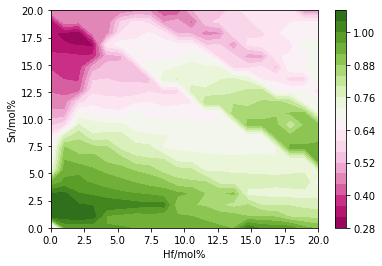

In [29]:

i = np.linspace(0,20,20)
j = np.linspace(0,20,20)
z = y_gen.reshape((20,20),order='A').T
# plt.plot(i,y_gen,linewidth=2)
plt.xlabel('Hf/mol%')
plt.ylabel('Sn/mol%')
# plt.ylabel('magnetic susceptibility/10^-6')
levels = plt.MaxNLocator(nbins=20).tick_values(z.min(), z.max())
plt.contourf(i,j,z,levels=levels,cmap=plt.colormaps['PiYG'])
plt.colorbar()

In [33]:
data = pd.read_csv('./dataset/x_y.csv')
corr = data.corr()
corr.to_csv('./corr.csv',index=False)